<h1>Transformer for Time Series Forecasting using PyTorch</h1>

<h2>Using torch.nn.TransformerEncoder</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>Transformer implementation using PyTorch's built-in modules</b> for time series forecasting. We use <code>torch.nn.TransformerEncoder</code> with custom positional encoding - industry-standard approach for working professionals.</p>

<h4>Components:</h4>
<ul>
  <li><b>torch.nn.TransformerEncoder</b>: Built-in multi-head attention + feed-forward layers</li>
  <li><b>Custom Positional Encoding</b>: Sinusoidal encoding (PE(pos, 2i) = sin, PE(pos, 2i+1) = cos)</li>
  <li><b>nn.TransformerEncoderLayer</b>: Single encoder block with self-attention</li>
  <li><b>Industry practice</b>: Standard library usage, not from scratch</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Use torch.nn.TransformerEncoder for time series</li>
  <li>✓ Implement custom positional encoding module</li>
  <li>✓ Configure transformer parameters (heads, layers, d_model)</li>
  <li>✓ Handle batch_first=True for sequence processing</li>
  <li>✓ Apply temporal train/test split (NO shuffling)</li>
  <li>✓ Compare transformer vs RNN performance</li>
</ul>

<hr>

<h3>Architecture</h3>
<pre>
Input (batch, seq_len, n_features)
   ↓
Linear projection → d_model
   ↓
+ PositionalEncoding (custom)
   ↓
nn.TransformerEncoder (n_layers)
  [MultiheadAttention + FFN]
   ↓
Mean pooling (global average)
   ↓
Linear (output_size)
</pre>

In [2]:
# Import Libraries
# pip install torch torchvision torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## PART 1: LOAD AND PREPROCESS TIME SERIES DATA

In [4]:
print("\n[1] Loading time series dataset...")

# Generate synthetic multivariate time series data
np.random.seed(42)
n_samples = 2000
time = np.arange(n_samples)

# Feature 1: Temperature (seasonal pattern)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.randn(n_samples) * 2

# Feature 2: Humidity (with trend)
humidity = 60 + 0.005 * time + 10 * np.sin(2 * np.pi * time / 180) + np.random.randn(n_samples) * 3

# Feature 3: Day of week (cyclic)
day_of_week = np.sin(2 * np.pi * time / 7)

# Target: Energy consumption
energy = (50 + 0.5 * temperature + 0.3 * humidity + 
          5 * np.sin(2 * np.pi * time / 7) + np.random.randn(n_samples) * 5)

# Create DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'day_of_week': day_of_week,
    'energy': energy
})

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())


[1] Loading time series dataset...
Dataset shape: (2000, 4)
Features: ['temperature', 'humidity', 'day_of_week', 'energy']

First few rows:
   temperature   humidity  day_of_week     energy
0    20.993428  57.974465     0.000000  73.571586
1    19.895605  59.920439     0.781831  81.677074
2    21.639593  58.330305     0.974928  83.283612
3    23.562256  60.136400     0.433884  84.354619
4    20.219718  55.730887    -0.433884  67.825414


## PART 2: TIME SERIES EXPLORATION AND VISUALIZATION

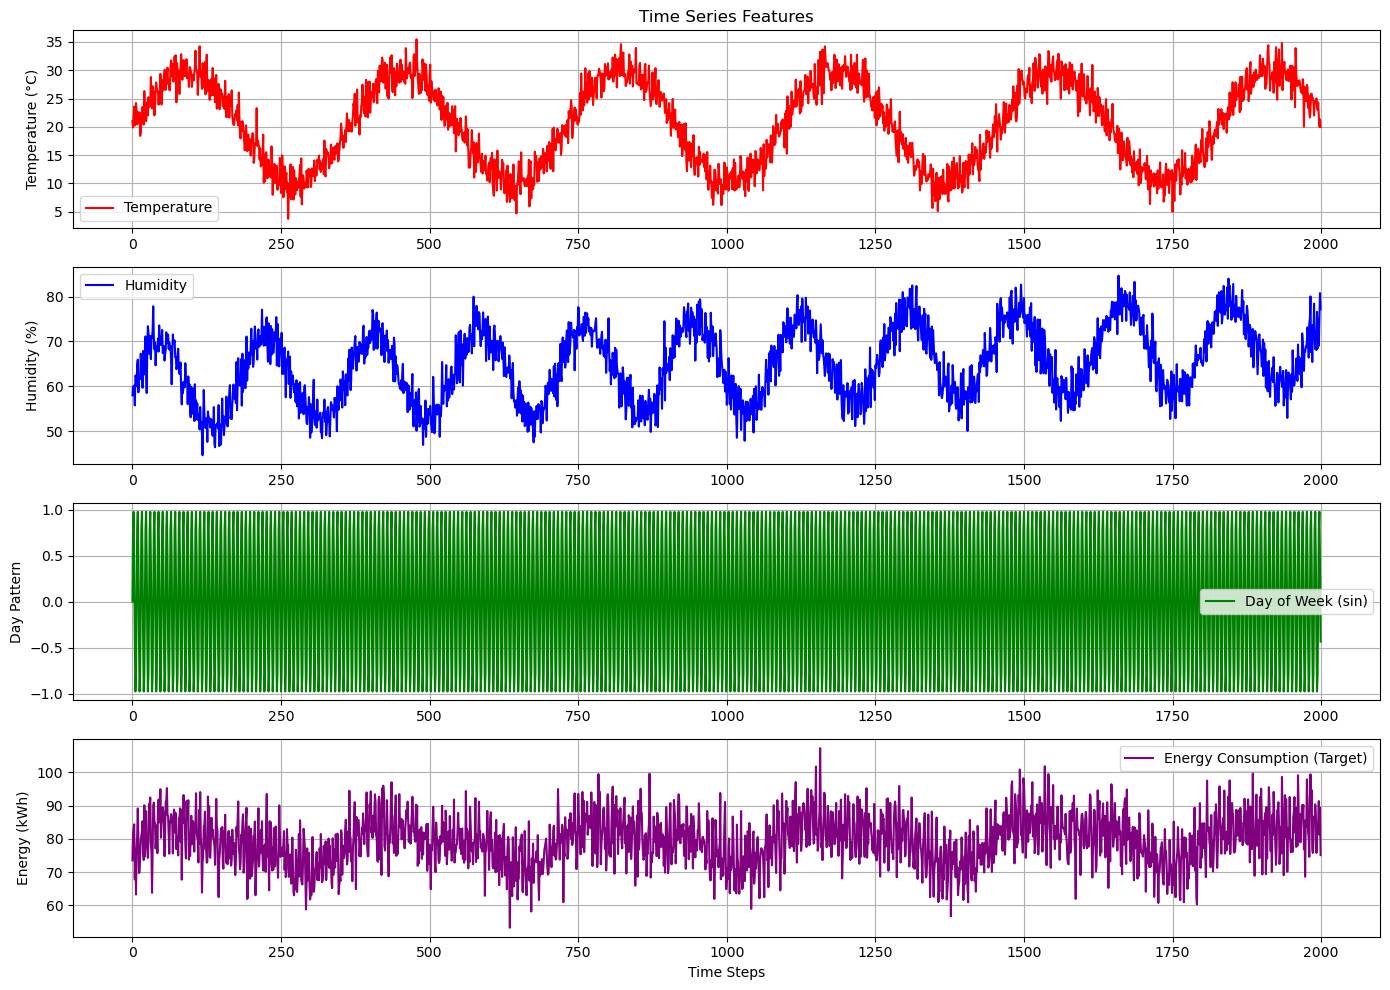

In [5]:
# Visualize time series
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(data['temperature'], label='Temperature', color='red')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Time Series Features')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data['humidity'], label='Humidity', color='blue')
axes[1].set_ylabel('Humidity (%)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(data['day_of_week'], label='Day of Week (sin)', color='green')
axes[2].set_ylabel('Day Pattern')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(data['energy'], label='Energy Consumption (Target)', color='purple')
axes[3].set_ylabel('Energy (kWh)')
axes[3].set_xlabel('Time Steps')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()

## PART 2: DATA PREPROCESSING

In [6]:
print("\n[2] Preprocessing time series data...")

# Normalize features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[['temperature', 'humidity', 'day_of_week']])
y_scaled = scaler_y.fit_transform(data[['energy']])

# Create sequences
def create_sequences(X, y, seq_length, pred_horizon=1):
    """Create sequences for time series forecasting"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length - pred_horizon + 1):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length:i + seq_length + pred_horizon])
    
    return np.array(X_seq), np.array(y_seq)

# Configuration
sequence_length = 30
prediction_horizon = 1

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length, prediction_horizon)

print(f"\nSequence shapes:")
print(f"X_sequences: {X_sequences.shape}")
print(f"y_sequences: {y_sequences.shape}")

# Temporal train/test split (NO SHUFFLING)
train_size = int(0.9 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\nTrain/Test Split (90/10 temporal):")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("IMPORTANT: Temporal split used (NO shuffling)")

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffling for time series

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


[2] Preprocessing time series data...

Sequence shapes:
X_sequences: (1970, 30, 3)
y_sequences: (1970, 1, 1)

Train/Test Split (90/10 temporal):
Training samples: 1773
Test samples: 197
IMPORTANT: Temporal split used (NO shuffling)


## PART 3: POSITIONAL ENCODING IMPLEMENTATION

In [7]:
print("\n[3] Implementing Positional Encoding...")

class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding for transformer
    
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model: dimension of the model
            max_len: maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add batch dimension: (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: input tensor (batch_size, seq_len, d_model)
        
        Returns:
            x with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

print("Positional encoding implemented")


[3] Implementing Positional Encoding...
Positional encoding implemented


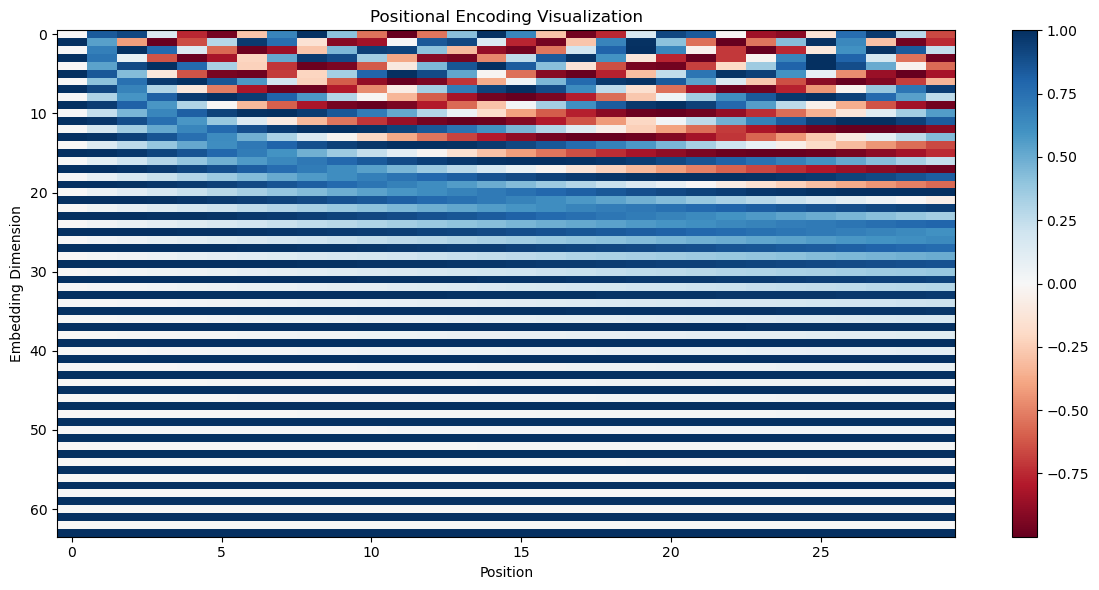

In [8]:
# Visualize positional encoding
pe_layer = PositionalEncoding(d_model=64, max_len=sequence_length)
sample_pe = pe_layer.pe[0, :sequence_length, :].cpu().numpy()

plt.figure(figsize=(12, 6))
plt.imshow(sample_pe.T, aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Embedding Dimension')
plt.title('Positional Encoding Visualization')
plt.tight_layout()

## PART 4: BUILD TRANSFORMER MODEL

In [9]:
print("\n[4] Building Transformer model using torch.nn.TransformerEncoder...")

class TransformerModel(nn.Module):
    """
    Transformer model for time series forecasting
    Uses torch.nn.TransformerEncoder with custom positional encoding
    """
    
    def __init__(self, n_features, d_model, n_heads, n_layers, d_ff, output_size, dropout=0.1):
        """
        Args:
            n_features: number of input features
            d_model: dimension of the model (embedding size)
            n_heads: number of attention heads
            n_layers: number of transformer encoder layers
            d_ff: dimension of feed-forward network
            output_size: prediction horizon
            dropout: dropout rate
        """
        super(TransformerModel, self).__init__()
        
        self.d_model = d_model
        
        # Input projection layer
        self.input_projection = nn.Linear(n_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True  # Input shape: (batch, seq, feature)
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=n_layers
        )
        
        # Output layers
        self.fc = nn.Linear(d_model, output_size)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: input tensor (batch_size, seq_len, n_features)
        
        Returns:
            output predictions (batch_size, output_size)
        """
        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Global average pooling over sequence dimension
        x = x.mean(dim=1)  # (batch, d_model)
        
        # Output layer
        output = self.fc(x)  # (batch, output_size)
        
        return output


[4] Building Transformer model using torch.nn.TransformerEncoder...


In [10]:
# Model configuration
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 128
dropout = 0.1

# Create model
model = TransformerModel(
    n_features=X_train.shape[2],
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    output_size=prediction_horizon,
    dropout=dropout
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTransformer Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("\nModel structure:")
print(model)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Transformer Model Architecture:
Total parameters: 67,265
Trainable parameters: 67,265

Model structure:
TransformerModel(
  (input_projection): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=1, bias=True

## PART 5: TRAIN TRANSFORMER MODEL

In [11]:
print("\n[5] Training Transformer model...")

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')



[5] Training Transformer model...
Epoch [10/50] - Train Loss: 0.019949, Val Loss: 0.026089
Epoch [20/50] - Train Loss: 0.015123, Val Loss: 0.016284
Epoch [30/50] - Train Loss: 0.015310, Val Loss: 0.020666
Epoch [40/50] - Train Loss: 0.015892, Val Loss: 0.018030
Epoch [50/50] - Train Loss: 0.015292, Val Loss: 0.017104


In [12]:
# Track initial and final loss
transformer_initial_loss = train_losses[0]
transformer_final_loss = train_losses[-1]

print(f"\nInitial Loss: {transformer_initial_loss:.6f}")
print(f"Final Loss: {transformer_final_loss:.6f}")
print(f"Loss Decreased: {transformer_final_loss < transformer_initial_loss}")


Initial Loss: 0.085539
Final Loss: 0.015292
Loss Decreased: True


## PART 6: EVALUATE TRANSFORMER MODEL

In [14]:
print("\n[6] Evaluating Transformer model on test set...")
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Convert to numpy arrays
transformer_pred_scaled = np.array(all_predictions).reshape(-1, 1)
y_test_scaled = np.array(all_targets).reshape(-1, 1)

# Inverse transform
transformer_pred = scaler_y.inverse_transform(transformer_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Calculate metrics
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

transformer_mae = mean_absolute_error(y_test_actual, transformer_pred)
transformer_rmse = np.sqrt(mean_squared_error(y_test_actual, transformer_pred))
transformer_mape = calculate_mape(y_test_actual, transformer_pred)
transformer_r2 = r2_score(y_test_actual, transformer_pred)

print("TRANSFORMER MODEL PERFORMANCE")
print(f"MAE:      {transformer_mae:.4f}")
print(f"RMSE:     {transformer_rmse:.4f}")
print(f"MAPE:     {transformer_mape:.4f}%")
print(f"R² Score: {transformer_r2:.4f}")


[6] Evaluating Transformer model on test set...
TRANSFORMER MODEL PERFORMANCE
MAE:      5.7780
RMSE:     7.1138
MAPE:     7.1484%
R² Score: -0.0838


## PART 7: VISUALIZATIONS


[7] Generating visualizations...


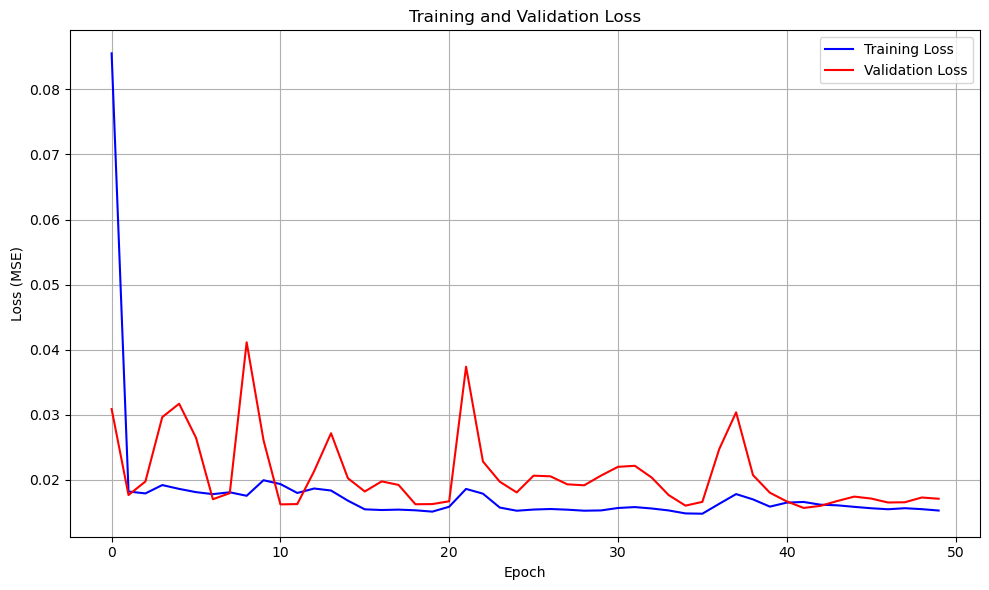

In [15]:
print("\n[7] Generating visualizations...")

# Plot training history
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_losses, label='Training Loss', color='blue')
ax.plot(val_losses, label='Validation Loss', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True)
plt.tight_layout()

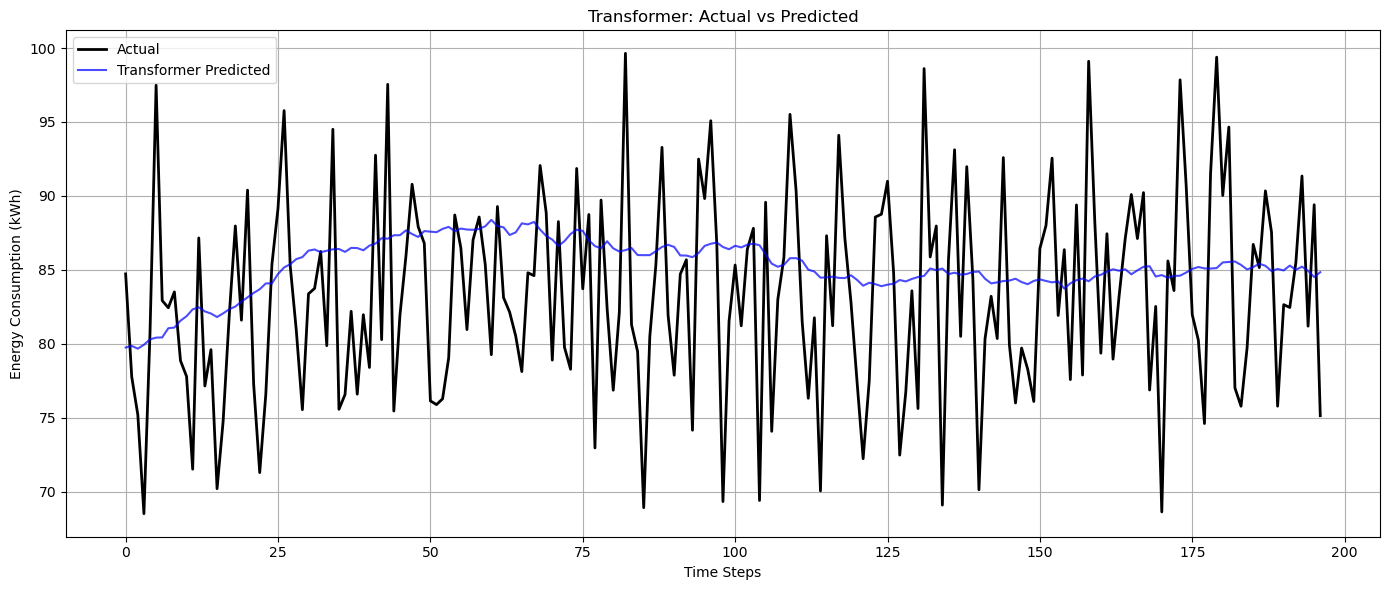

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual', color='black', linewidth=2)
plt.plot(transformer_pred, label='Transformer Predicted', color='blue', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Transformer: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()

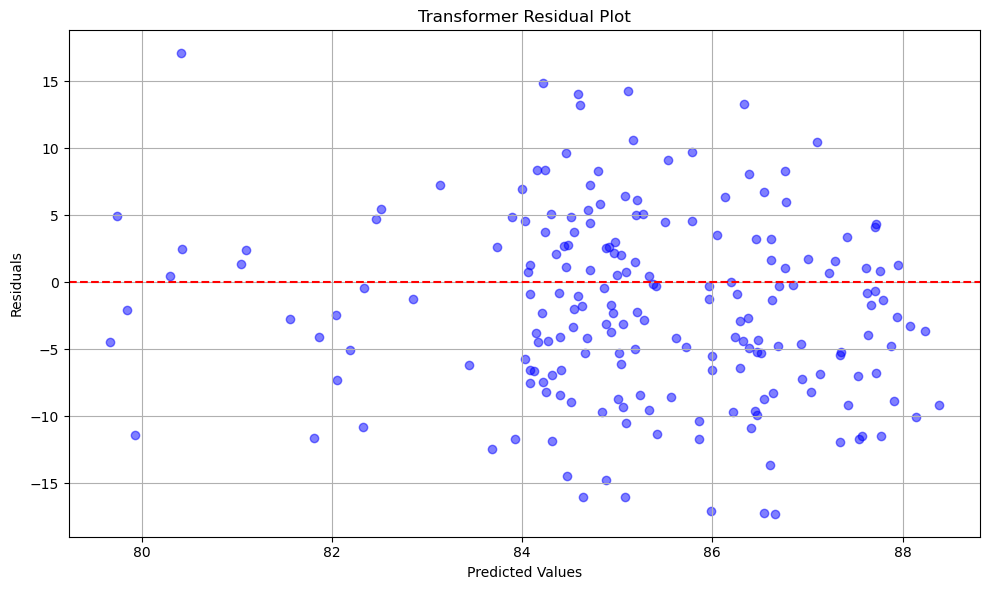

In [17]:
# Plot residuals
plt.figure(figsize=(10, 6))
transformer_residuals = y_test_actual.flatten() - transformer_pred.flatten()
plt.scatter(transformer_pred, transformer_residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Transformer Residual Plot')
plt.grid(True)
plt.tight_layout()

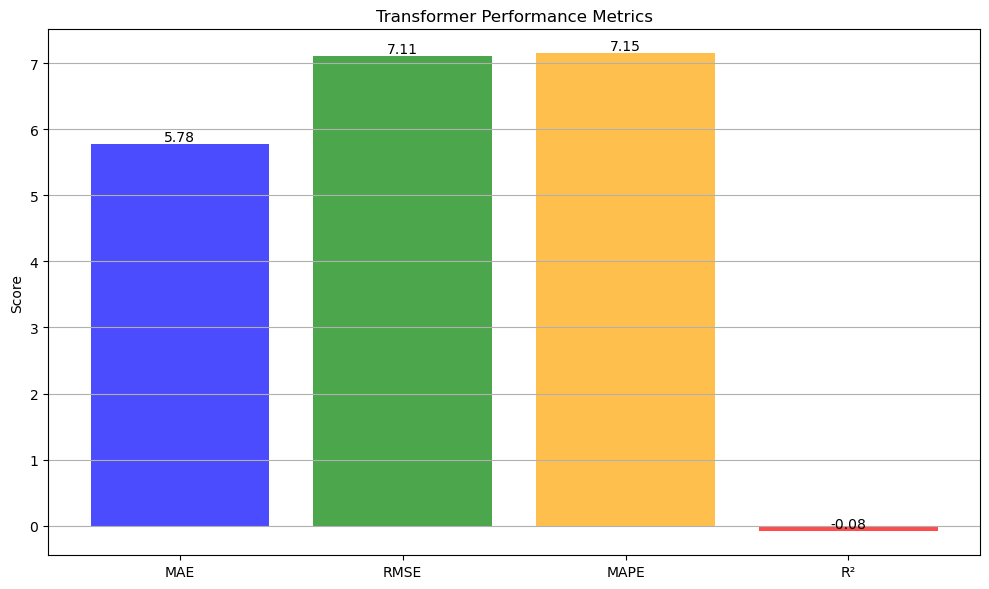

In [18]:
# Metrics bar chart
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['MAE', 'RMSE', 'MAPE', 'R²']
scores = [transformer_mae, transformer_rmse, transformer_mape, transformer_r2]

bars = ax.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
ax.set_ylabel('Score')
ax.set_title('Transformer Performance Metrics')
ax.grid(True, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()

In [19]:
print("TRANSFORMER TIME SERIES FORECASTING COMPLETE") 
print(f"Positional Encoding: Custom implementation (sinusoidal)")
print(f"Transformer Encoder: torch.nn.TransformerEncoder")
print(f"Transformer Layers: {n_layers}")
print(f"Attention Heads: {n_heads}")
print(f"Input: Multivariate (3 features)")
print(f"Output: Univariate (1 step ahead)")
print(f"Total Parameters: {total_params:,}")
print(f"Test MAE: {transformer_mae:.4f}")
print(f"Framework: PyTorch {torch.__version__}")

TRANSFORMER TIME SERIES FORECASTING COMPLETE
Positional Encoding: Custom implementation (sinusoidal)
Transformer Encoder: torch.nn.TransformerEncoder
Transformer Layers: 2
Attention Heads: 4
Input: Multivariate (3 features)
Output: Univariate (1 step ahead)
Total Parameters: 67,265
Test MAE: 5.7780
Framework: PyTorch 2.9.1+cu128


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Student Exercises</h3>

<h4>1. PyTorch Transformer Configuration</h4>
<ul>
  <li><b>Attention heads</b>: Try nhead=2, 4, 8, 16</li>
  <li><b>Encoder layers</b>: Experiment with num_layers=1, 2, 4, 6</li>
  <li><b>Model dimension</b>: Vary d_model (32, 64, 128, 256)</li>
  <li><b>Feed-forward size</b>: Change dim_feedforward (128, 256, 512)</li>
</ul>

<h4>2. Positional Encoding Variants</h4>
<ul>
  <li><b>Learnable positions</b>: Use nn.Embedding instead of sinusoidal</li>
  <li><b>Relative positions</b>: Implement relative positional bias</li>
  <li><b>No encoding</b>: Compare performance without positional info</li>
  <li><b>Concatenate vs Add</b>: Try concatenating PE instead of adding</li>
</ul>

<h4>3. Advanced PyTorch Features</h4>
<ul>
  <li><b>Masking</b>: Add src_mask for causal (autoregressive) prediction</li>
  <li><b>Key padding mask</b>: Handle variable-length sequences</li>
  <li><b>Mixed precision</b>: Use torch.cuda.amp for faster training</li>
  <li><b>Learning rate warmup</b>: Implement transformer-style LR scheduling</li>
</ul>

<h4>4. Architecture Enhancements</h4>
<ul>
  <li><b>Encoder-Decoder</b>: Use nn.Transformer (full architecture)</li>
  <li><b>Multi-query attention</b>: Reduce memory for long sequences</li>
  <li><b>Flash Attention</b>: Use optimized attention implementations</li>
  <li><b>Hybrid models</b>: Combine with CNN or LSTM layers</li>
</ul>

<h4>5. Training Improvements</h4>
<ul>
  <li><b>Gradient clipping</b>: Use torch.nn.utils.clip_grad_norm_</li>
  <li><b>Label smoothing</b>: Regularization for better generalization</li>
  <li><b>Early stopping</b>: Monitor validation loss</li>
  <li><b>Model checkpointing</b>: Save best weights during training</li>
</ul>

<h4>6. Real-World Applications</h4>
<ul>
  <li>Stock price prediction (multivariate time series)</li>
  <li>Weather forecasting (temperature, pressure, humidity)</li>
  <li>Energy demand forecasting (load prediction)</li>
  <li>Sensor anomaly detection (IoT data)</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Achieve <b>better accuracy than LSTM/GRU</b> on same dataset</li>
  <li>Build <b>encoder-decoder</b> with nn.Transformer for multi-step prediction</li>
  <li>Implement <b>attention visualization</b> to interpret predictions</li>
  <li>Apply to <b>long sequences (>100 steps)</b> with efficient attention variants</li>
</ol>

<hr>
<h4><center>Happy coding</center></h4>